# Prepare the document store

In [1]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.types import DuplicatePolicy

# Initialize the document store
document_store = InMemoryDocumentStore()

# Fetch the data and convert it into Haystack Documents
dataset = load_dataset("covid_qa_deepset", split="train")
unique_text = set(dataset["context"])
chunk_size = 2000
text_chunks = []
for text in unique_text:
    text_chunks = text_chunks + [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
docs = [Document(content=doc) for doc in text_chunks]

# Initalize a Document Embedder
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/multi-qa-mpnet-base-dot-v1")
doc_embedder.warm_up()

# Write Documents to the DocumentStore
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"], policy=DuplicatePolicy.SKIP)


/home/ec2-user/SageMaker/custom-miniconda/miniconda/envs/Tutorial-LLM/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2005

# Build RAG pipeline

## Set up pipeline components

In [2]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

# Initialize a Text Embedder
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/multi-qa-mpnet-base-dot-v1")

# Initialize the Retriever
retriever = InMemoryEmbeddingRetriever(document_store)

# Define a Template Prompt
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

# Initialize a Generator
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")
generator = OpenAIGenerator(model="gpt-3.5-turbo")

Enter OpenAI API key:  ········


## Build the pipeline

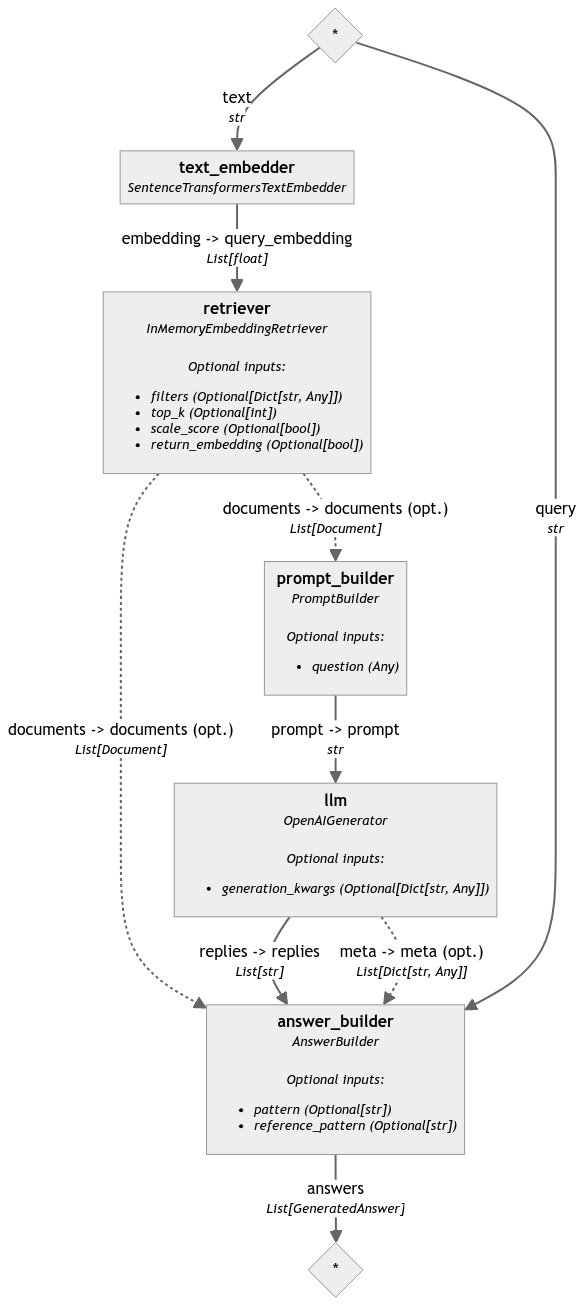

In [3]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("llm.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")

## Ask questions

In [9]:
# Function to get both response and retrieved context
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "text_embedder": {"text": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses

In [19]:
questions = ["HWhat is the main cause of HIV-1 infection in children?"]
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

['The main cause of HIV-1 infection in children is mother-to-child transmission (MTCT) of the virus.']

In [20]:
contexts[0]

[' of DC-SIGNR, particularly the membranebound isoforms, on placental capillary endothelial cells might favour HIV-1 binding to CCR5 receptor, instead of DC-SIGNR receptor, facilitating the migration of maternal HIV-1-infected cells across the placental barrier resulting in IU transmission of HIV-1.\n\nThe int2-180A variant contained in the H1 and H3 haplotypes was associated with IP transmission suggesting that DC-SIGNR also affect transmission of HIV-1 during delivery. Little is known about the mechanisms underlying transmission of HIV-1 during delivery. Passage through the birth canal could potentially expose infants through a mucosal portal entry (presumably ophthalmic, skin, or gastrointestinal), whereas placental insult during delivery (physical or inflammatory) may enhance transplacental passage of maternal HIV-1-infected cells into foetal circulation [22, 23] . Such process called microtransfusion has been proposed in regards to the results obtain in a Malawian cohort. Kweik an

In [21]:
questions = ["What could trigger acute necrotizing encephalopathy?"]
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

['Based on the information provided, acute necrotizing encephalopathy could be triggered by infectious agents such as viruses, particularly in previously healthy individuals with certain gene mutations. Other triggers could include inflammatory responses, disruption of neuronal energy homeostasis, and susceptibility to infection-induced necrotizing encephalopathy.']

In [22]:
contexts[0]

[' as the MRI findings were not consistent with a specific vascular territory and normal arterial and venous flows were shown on vascular imaging. Another differential is posterior reversible encephalopathy syndrome which has been reported in SCD patients (13) (14) (15) (16) . However, it is unlikely in our case due to the severity of the brain injury and the absence of classic precipitating factors of posterior reversible encephalopathy syndrome such as high blood pressure. Macrophage activation syndrome could also lead to acute necrotic brain injury. However, it is associated to high ferritin and low triglycerides at the time of the encephalopathy, other multisystemic injuries, typical neuropathological findings, and recurrence over time, which were not noted in our patient (17) . Parvovirus B19 has been described to cause encephalopathy in sickle cell patients. It is associated with aplastic anemia. It caused punctate areas of hemorrhages in the basal ganglia, periventricular white 